In [30]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import heapq
import re
import concurrent.futures
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error



In [149]:
# def getValue1(df, field):
#     result_dict_values = {}
#     result_dict_values[field] = []
#     for row in df.itertuples():
#         if field in row.results:
#             try:
#                 result = eval(row.results)[field]
#                 result_dict_values[field].append(result)
#             except:
#                 pass
#     return result_dict_values

# def getValue2(df, field):
#     result_dict_values = {field: df.loc[df['results'].str.contains(field), 'results'].str.extract(r'\"{}\":\s*(\d+)'.format(field), expand=False).dropna().astype(float).tolist()}
#     return result_dict_values

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor



import pickle
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve

In [102]:
def showPic(methodName, y_test, y_pred):
    # 创建柱状图
    #plt.figure(figsize=(80, 15))
    plt.subplot(1, 2, 1)
    # 创建样本索引数组
    index = np.arange(len(y_test))
    # 绘制线性回归模型的折线图
    plt.plot(index, y_test, label='True Values')
    plt.plot(index, y_pred, label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title('{}: True Values vs. Predicted Values'.format(methodName))
    plt.legend()
    plt.show()



def showCoef(linear_reg, decision_tree_reg, random_forest_reg):
    # 绘制特征重要性条形图
    if len(linear_reg.coef_) > 1:
        coef_abs = np.abs(linear_reg.coef_)
        sorted_idx = np.argsort(coef_abs)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(coef_abs)), coef_abs[sorted_idx])
        plt.xticks(range(len(coef_abs)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance (by coefficient absolute value)')
        plt.title('Linear Regression - Feature Importance')
        plt.show()
    else:
        print('Linear Regression - No feature importance to plot')

    if len(decision_tree_reg.feature_importances_) > 1:
        feature_importances = decision_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
        plt.xticks(range(len(feature_importances)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Decision Tree - Feature Importance')
        plt.show()
    else:
        print('Decision Tree - No feature importance to plot')

    if len(random_forest_reg.feature_importances_) > 1:
        feature_importances = random_forest_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
        plt.xticks(range(len(feature_importances)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Random Forest - Feature Importance')
        plt.show()
    else:
        print('Random Forest - No feature importance to plot')

def showCoef_new( decision_tree_reg):
    # 绘制特征重要性条形图
    if len(decision_tree_reg.feature_importances_) > 1:
        feature_importances = decision_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        #plt.figure(figsize=(150, 20))
        plt.figure()
        last_five=sorted_idx[-5:]
        plt.bar(range(5), feature_importances[last_five])
        plt.xticks(range(5), last_five)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Decision Tree - Feature Importance')
        plt.show()
    else:
        print('Decision Tree - No feature importance to plot')



def getCoef( decison_tree_reg):
    result = []
    # 
    if len(decison_tree_reg.feature_importances_) > 1:
        feature_importances = decison_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    return result


# def getFeatureName(result, inputDF):
#     feature_names = inputDF.columns
#     linear_reg_indices = result[0]  # 线性回归模型的特征索引
#     decision_tree_indices = result[1]  # 决策树模型的特征索引
#     random_forest_indices = result[2]  # 随机森林模型的特征索引

#     linear_reg_feature_names = feature_names[linear_reg_indices].tolist()  # 线性回归模型的特征列名列表
#     decision_tree_feature_names = feature_names[decision_tree_indices].tolist()  # 决策树模型的特征列名列表
#     random_forest_feature_names = feature_names[random_forest_indices].tolist()  # 随机森林模型的特征列名列表
    
#     linear_reg_features = inputDF[linear_reg_feature_names]  # 线性回归模型的特征值
#     decision_tree_features = inputDF[decision_tree_feature_names]  # 决策树模型的特征值
#     random_forest_features = inputDF[random_forest_feature_names]  # 随机森林模型的特征值


def showDecisonTree(decision_tree_reg, flag=False):
    if flag:    
        plt.figure(figsize=(20, 10))  # 设置画布大小
        plot_tree(decision_tree_reg, max_depth=2, feature_names=None, filled=True, rounded=True)  # 设置最大深度为2，可以根据需要调整
        plt.title('Decision Tree')
        plt.show()


def showRandomForest(random_forest_reg, flag=False):
    if flag:
        if len(random_forest_reg.feature_importances_) > 1:
            # 获取特征重要性
            feature_importances = random_forest_reg.feature_importances_
            # 选择特征重要性最高的决策树
            best_tree_index = np.argmax(feature_importances)
            if best_tree_index >= random_forest_reg.n_estimators:
                best_tree_index = random_forest_reg.n_estimators - 1

            plt.figure(figsize=(20, 10))
            plot_tree(random_forest_reg.estimators_[best_tree_index], max_depth=2, feature_names=None, filled=True, rounded=True)
            plt.title('Best Decision Tree')
            plt.show()
        else:
            print('Random Forest - No feature importance to plot')


def getModel(X_train, y_train, save_path):
    # 初始化模型
    decision_tree_reg = DecisionTreeRegressor(splitter="best")  #“random”表示分枝时会更加随机，常用来防止过拟合
    knn_reg = KNeighborsRegressor(n_neighbors=7)    #应该是比较适合大量数据
    xgb_reg = xgb.XGBRegressor()
    params = {
    'n_estimators': 400, 
    'max_depth': 11,
    'learning_rate': 0.06,
    'loss': 'ls',
    'subsample':0.8
     }
    gbdt_reg=GradientBoostingRegressor(**params)

    # 拟合模型
    decision_tree_reg.fit(X_train, y_train)
    knn_reg.fit(X_train, y_train)
    xgb_reg.fit(X_train, y_train)
    gbdt_reg.fit(X_train, y_train)

    # 保存模型
    models = {
        #'linear_reg': linear_reg,
        'decision_tree_reg': decision_tree_reg,
        'knn_reg': knn_reg,
        'xgb_reg':xgb_reg,
        'gbdt_reg':gbdt_reg
    }
    # save_path = 'model/'
    for model_name, model in models.items():
        with open(save_path + model_name + '.pkl', 'wb') as f:
            pickle.dump(model, f)

    #return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg, xgb_reg, gbm_reg, gbdt_reg
    return decision_tree_reg, knn_reg, xgb_reg, gbdt_reg


def train(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    #linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg, xgb_reg, gbm_reg, gbdt_reg = getModel(X_train, y_train, save_path)
    decision_tree_reg, knn_reg, xgb_reg, gbdt_reg = getModel(X_train, y_train, save_path)

    # # 绘制KNN的学习曲线,选出最优的K值  #已选出:7
    # plt.figure()
    # score = []
    # krange = range(1,20,1)
    # for i in krange:
    #     clf = KNeighborsRegressor(n_neighbors = i)#n_neighbors：取邻近点的个数k
    #     clf.fit(X_train, y_train)
    #     score.append(clf.score(X_test, y_test))
    # plt.plot(krange, score)
    
    # 预测
    #y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)
    y_pred_xgb_reg = xgb_reg.predict(X_test)
    y_pred_gbdt_reg = gbdt_reg.predict(X_test)

    #用R^2判断模型的拟合程度，MAPE判断预测值的误差。较好模型的R^2应高于0.8，或者MAPE低于5%
    # 计算评估指标  越接近1模型越好
    #r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)
    r2_xgb_reg = r2_score(y_test, y_pred_xgb_reg)
    r2_gbdt_reg = r2_score(y_test, y_pred_gbdt_reg)

    #计算MAPE指标  越接近0模型越好,大于1就是劣质模型
    #Linear_MAPE = mean_absolute_percentage_error(y_test, y_pred_linear_reg)
    Decision_tree_MAPE = mean_absolute_percentage_error(y_test, y_pred_decision_tree_reg)
    Knn_MAPE = mean_absolute_percentage_error(y_test, y_pred_knn_reg)
    xgb_MAPE = mean_absolute_percentage_error(y_test, y_pred_xgb_reg)
    gbdt_MAPE = mean_absolute_percentage_error(y_test, y_pred_gbdt_reg)

    #print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg)))
    print('{:<30} {:>10}'.format('XGBOOST R2:', '{:.8f}'.format(r2_xgb_reg)))
    print('{:<30} {:>10}'.format('GBDT R2:', '{:.8f}'.format(r2_gbdt_reg)))
    print('\n')

    #print('{:<30} {:>10}'.format('Linear Regression MAPE:', '{:.8f}'.format(Linear_MAPE)))
    print('{:<30} {:>10}'.format('Decision Tree MAPE:', '{:.8f}'.format(Decision_tree_MAPE)))
    print('{:<30} {:>10}'.format('KNN MAPE:', '{:.8f}'.format(Knn_MAPE)))
    print('{:<30} {:>10}'.format('XGBOOST MAPE:', '{:.8f}'.format(xgb_MAPE)))
    print('{:<30} {:>10}'.format('GBDT MAPE:', '{:.8f}'.format(gbdt_MAPE)))
    print('\n')
    
    
    models = []
    getModelList = []
    
    if r2_decision_tree_reg > 0.8:
        models.append("Decision Tree Regression")
        getModelList.append("decision_tree_reg")
    if r2_knn_reg > 0.8:
        models.append("KNN Regression")
        getModelList.append("knn_reg")
    if r2_xgb_reg > 0.8:
        models.append("XGB Regressor")
        getModelList.append("xgb_reg")
    if r2_gbdt_reg > 0.8:
        models.append("GBDT")
        getModelList.append("gbdt_reg")
        
    for i in range(len(models)):
        judgeResult(eval(getModelList[i]), X_train, y_train, X_test, y_test)
        
    return decision_tree_reg, knn_reg ,xgb_reg , gbdt_reg


def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
   
    # 判断过拟合
    if train_scores_mean.all() < test_scores_mean.all():
        print("模型可能存在过拟合的问题\n\n")
    else:
        print("模型可能没有过拟合的问题\n\n")
         #画图
        plt.figure(figsize=(10, 6))
        plt.ylim((0.8, 1))
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label=model.__class__.__name__+": Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
                 label="Cross-validation score")
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()


def judgeResult(model, X_train, y_train, X_test, y_test):
    # 在训练集和测试集上计算评估指标
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print('Model: {}'.format(model.__class__.__name__))
    print('{:<30} {:>10}'.format('Train R2:', '{:.8f}'.format(r2_train)))
    print('{:<30} {:>10}'.format('Test R2:', '{:.8f}'.format(r2_test)))
    
    #绘制学习曲线
    plot_learning_curve(model, X_train, y_train)




## 处理result_key中的内容

In [103]:
rk=pd.read_csv('./data/x and y columns 2.0.csv',encoding="unicode_escape")
#print(rk['results_key'][0])
#print(len(rk))
threads=[]
gcc_oflag=[]
unixbench_cpu=[]
for i in range(len(rk)):
    judge=0
    temp=rk['results_key'][i].split(',')
    for j in range(len(temp)):
        if temp[j][0:7]=="threads":
            t1=j
            judge+=1
        if temp[j][0:9]=="gcc_oflag":
            t2=j
            judge+=1
    if judge == 2:
        if(temp[t1][8:]=="cpu"):
            a=80
        else:
            a=int(temp[t1][8:])
        # #编码cpu：
        # a=temp[t1][8:]
        # #b=temp[t2][11:]
        b=int(temp[t2][11:])
        threads.append(a)
        gcc_oflag.append(b)
        unixbench_cpu.append(rk['#unixbench_cpu'][i])
print(len(threads))
print(len(gcc_oflag))
print(len(unixbench_cpu),'\n')
print(threads[0:5])
print(gcc_oflag[0:5])
print(unixbench_cpu[0:5])
threads=pd.DataFrame(threads)
gcc_oflag=pd.DataFrame(gcc_oflag)
output=pd.DataFrame(unixbench_cpu)
input=pd.concat([gcc_oflag, threads], axis=1)
input.columns = ['gcc_oflag','threads']
output.columns = ['unixbench_cpu']
# #bianma
# input = pd.get_dummies(input, columns=['threads'])
print(input.head())
print(output.head())


23113
23113
23113 

[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]
[2364, 3265, 3054, 3063, 3051]
   gcc_oflag  threads
0          0        1
1          0        1
2          0        1
3          0        1
4          0        1
   unixbench_cpu
0           2364
1           3265
2           3054
3           3063
4           3051


d:\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Decision Tree R2:              0.94812182
KNN R2:                        0.94291487
XGBOOST R2:                    0.94826831
GBDT R2:                       0.94857466


Decision Tree MAPE:            0.19668888
KNN MAPE:                      0.19742883
XGBOOST MAPE:                  0.19667662
GBDT MAPE:                     0.19673186


Model: DecisionTreeRegressor
Train R2:                      0.95593200
Test R2:                       0.94812182
模型可能没有过拟合的问题




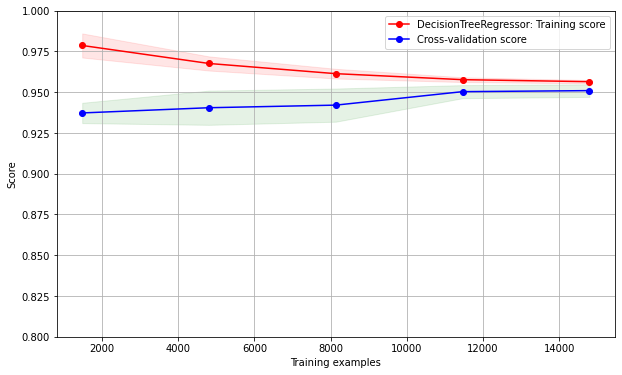

Model: KNeighborsRegressor
Train R2:                      0.94954771
Test R2:                       0.94291487
模型可能没有过拟合的问题




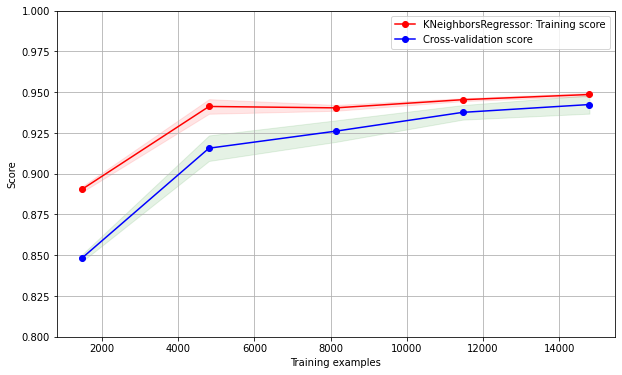

Model: XGBRegressor
Train R2:                      0.95593195
Test R2:                       0.94826831
模型可能没有过拟合的问题




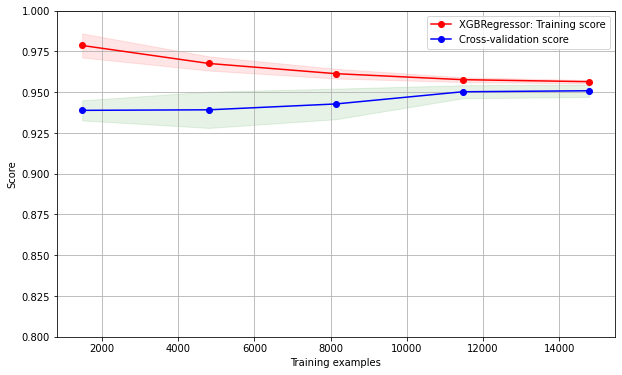

Model: GradientBoostingRegressor
Train R2:                      0.95592422
Test R2:                       0.94857466
模型可能没有过拟合的问题




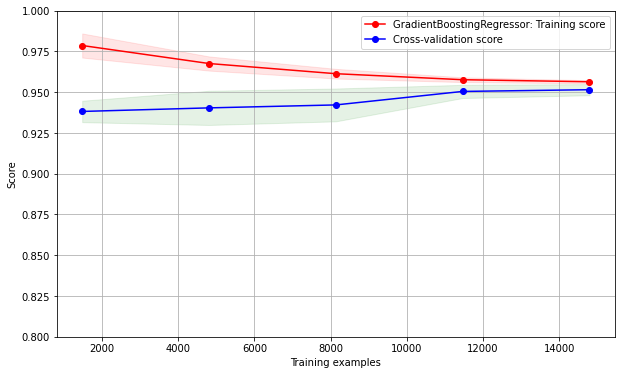

In [104]:
save_path = 'model_new/'
# 判断是否有这个文件夹，没有就创建 
if not os.path.exists(save_path):
    os.makedirs(save_path)
decision_tree_reg, knn_reg, xgb_reg, gbdt_reg= train(input, output, save_path)

1.  观察训练集和测试集上的模型性能：如果模型在训练集上表现很好但在测试集上表现较差，可能是模型过拟合了。可以通过比较训练集和测试集上的评估指标（如R2分数）来观察模型的性能差异。如果模型在训练集上的性能远远优于测试集，可能存在过拟合的问题。

2.  绘制学习曲线：可以绘制模型的学习曲线，观察模型在训练集和测试集上的性能随着训练样本数量增加而变化。如果模型在训练集上的性能持续提高而在测试集上的性能趋于稳定，可能存在过拟合的问题。

In [105]:
def processUnknowData1(testX):
    # processUnknowData1用于处理testX数据中所有的类别特征都在训练数据中出现过的情况
    testX_one_hot = pd.get_dummies(testX, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'])
    # 筛选出 testX_one_hot 中在 inputDF 中出现的列
    common_columns = testX_one_hot.columns.intersection(inputDF.columns)
    # 使用筛选后的列重新生成 testX
    testX = testX_one_hot[common_columns]

    # 将训练数据和测试数据合并后再进行独热编码
    combined_df = pd.concat([inputDF, testX], axis=0)
    one_hot_df = pd.get_dummies(combined_df, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'], dummy_na=False)

    # 分割合并后的数据，得到编码后的测试数据
    testX = one_hot_df.iloc[-1, :].values.reshape(1, -1)
    print(testX.shape)
    return testX


def processUnknowData2(testX):
    # processUnknowData2用于处理testX数据中可能包含了训练数据集中不存在的类别值
    testDict = {'cvm_cpu': '96', 'cvm_memory': '376', 'cvm_cpu_qos': 'cvm_cpu_qos', 'cvm_os_type': 'CentOS Linux release 7.6.181dsfsd0 (Core)', 'results_key': 'gcc_oflsdfsfdag=O3,threads=1'}

    for i, key in enumerate(testDict.keys()):
        testDict[key] = testX[i]

    max_key_length = max(len(key) for key in testDict.keys())
    for key, value in testDict.items():
        print('key: {:<{}} \tvalue: {}'.format(key, max_key_length, value))

    testDict = pd.DataFrame(testDict, index=[0])
    testDict['cvm_cpu'] = pd.to_numeric(testDict['cvm_cpu'])
    testDict['cvm_memory'] = pd.to_numeric(testDict['cvm_memory'])
    one_hot_df = pd.get_dummies(testDict, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'], dummy_na=False)

    # 获取 inputDF 中的特征列顺序
    inputDF_columns = X.columns.tolist()
    # 添加缺失的列，并将其值设置为 0
    missing_columns = list(set(inputDF_columns) - set(one_hot_df.columns))
    for column in missing_columns:
        one_hot_df[column] = 0

    # 按照 inputDF 列的顺序重新排列 one_hot_df
    one_hot_df = one_hot_df[inputDF_columns]

    # 确保编码后的维度与 inputDF 一致
    testX_encoded = one_hot_df.values.reshape(1, -1)
    print(testX_encoded.shape)
    return testX_encoded


def processData(testX, num):
    if num == 1:
        testX = processUnknowData1(testX)
    elif num == 2:
        testX = processUnknowData2(testX)
    else:
        print('num must be 1 or 2')
    return testX


In [106]:
#testX = ['8','40','true','CentOS Linux release 7.3.1611 (Core)','gcc_oflag=O0,threads=1']
testY = 2364
aa=[0]
bb=[1]
aa=pd.DataFrame(aa)
bb=pd.DataFrame(bb)

testX_encoded = pd.concat([aa, bb], axis=1)
testX_encoded.columns = ['gcc_oflag','threads']
print(testX_encoded)
#testX_encoded = processData(testX, 2)

   gcc_oflag  threads
0          0        1


In [107]:
def predict(X, load_path):
    # 加载保存的模型
    model = [ 'decision_tree_reg', 'knn_reg', 'xgb_reg', 'gbdt_reg']
    result = []
    for model_name in model:
        with open(os.path.join(load_path, model_name + '.pkl'), 'rb') as f:
            models = pickle.load(f)
        preRes = models.predict(X)
        if model_name == "knn_reg":
            print(model_name,"'s acc: ",round(1-abs(preRes[0][0]-testY)/testY, 2))
        else:
            print(model_name,"'s acc: ",round(1-abs(preRes[0]-testY)/testY, 2))
        result.append(preRes)

    numbers = [item.item() if isinstance(item, np.ndarray) and item.size == 1 else item for sublist in result for item in sublist]

    predictions = {}
    for i in range(len(model)):
        predictions[model[i]] = numbers[i]

    return predictions


def plot_predictions(predictions, y):
    keys = list(predictions.keys())
    values = list(predictions.values())
    
    plt.figure(figsize=(20, 10))
    #plt.figure()

    # 生成 x 轴的位置
    ind = np.arange(len(keys))
    
    # 设置柱状图的宽度
    width = 0.35
    
    # 用 plt 画柱状图，x 轴是 predictions 的 key，y 轴是 predictions 的 value 和 y 的值，一个 x 轴对应两个柱子
    plt.bar(ind, values, width, label='Predictions')
    plt.bar(ind + width, y, width, label='Actual')
    
    # 设置 x 轴标签和标题
    plt.xticks(ind + width / 2, keys)
    plt.xlabel('Model')
    plt.ylabel('Value')
    plt.title('Model Predictions vs Actual Value')
    
    plt.legend()
    plt.show()

In [108]:
predictions = predict(testX_encoded, save_path)

decision_tree_reg 's acc:  0.8
knn_reg 's acc:  0.86
xgb_reg 's acc:  0.8
gbdt_reg 's acc:  0.8


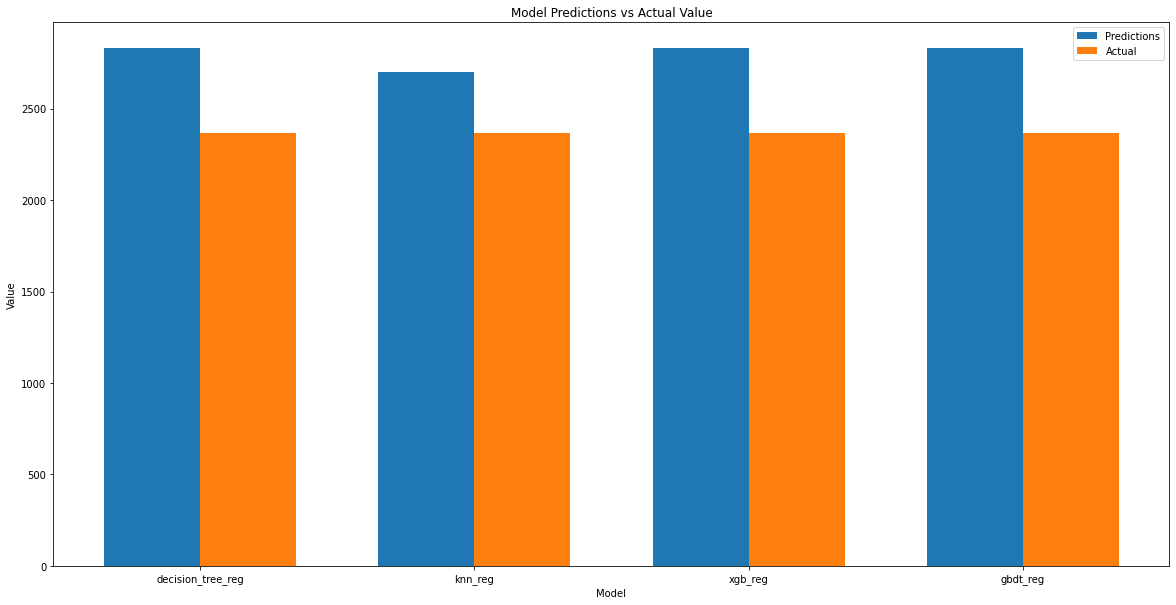

In [109]:
plot_predictions(predictions, testY)

## 多输出

In [112]:
# def getMultiModel(X_train, y_train, save_path):
#     # 初始化模型
#     decision_tree_reg = DecisionTreeRegressor(splitter="best")  #“random”表示分枝时会更加随机，常用来防止过拟合
#     knn_reg = KNeighborsRegressor(n_neighbors=7)    #应该是比较适合大量数据
#     xgb_reg = xgb.XGBRegressor()
#     #gbdt_reg=GradientBoostingRegressor()
#     params = {
#     'n_estimators': 400, 
#     'max_depth': 11,
#     'learning_rate': 0.06,
#     'loss': 'ls',
#     'subsample':0.8
#      }
#     gbdt_reg=GradientBoostingRegressor(**params)

#     # 使用MultiOutputRegressor包装模型
#     multioutput_decision_tree_reg = MultiOutputRegressor(decision_tree_reg)
#     multioutput_knn_reg = MultiOutputRegressor(knn_reg)
#     multioutput_xgb_reg = MultiOutputRegressor(xgb_reg)
#     multioutput_gbdt_reg = MultiOutputRegressor(gbdt_reg)

#     # 拟合模型
#     multioutput_decision_tree_reg.fit(X_train, y_train)
#     multioutput_xgb_reg.fit(X_train, y_train)
#     multioutput_gbdt_reg.fit(X_train, y_train)
#     multioutput_knn_reg.fit(X_train, y_train)

#     # 保存模型
#     models = {
#         'multioutput_decision_tree_reg': multioutput_decision_tree_reg,
#         'multioutput_xgb_reg': multioutput_xgb_reg,
#         'multioutput_gbdt_reg': multioutput_gbdt_reg,
#         'multioutput_knn_reg': multioutput_knn_reg,
#     }
#     # save_path = 'model/'
#     for model_name, model in models.items():
#         with open(save_path + model_name + '.pkl', 'wb') as f:
#             pickle.dump(model, f)

#     return  multioutput_decision_tree_reg, multioutput_xgb_reg, multioutput_gbdt_reg, multioutput_knn_reg


# def trainMulti(X, y, save_path):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#     # 获取模型
#     multioutput_decision_tree_reg, multioutput_xgb_reg, multioutput_gbdt_reg, multioutput_knn_reg = getMultiModel(X_train, y_train, save_path)

#     # 预测
#     y_pred_multioutput_decision_tree_reg = multioutput_decision_tree_reg.predict(X_test)
#     y_pred_multioutput_xgb_reg = multioutput_xgb_reg.predict(X_test)
#     y_pred_multioutput_gbdt_reg = multioutput_gbdt_reg.predict(X_test)
#     y_pred_multioutput_knn_reg = multioutput_knn_reg.predict(X_test)

#     # 计算评估指标
#     r2_multioutput_decision_tree_reg = r2_score(y_test, y_pred_multioutput_decision_tree_reg)
#     r2_multioutput_xgb_reg = r2_score(y_test, y_pred_multioutput_xgb_reg)
#     r2_multioutput_gbdt_reg = r2_score(y_test, y_pred_multioutput_gbdt_reg)
#     r2_multioutput_knn_reg = r2_score(y_test, y_pred_multioutput_knn_reg)
    
#     print('{:<30} {}'.format('Multi-Output Decision Tree R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_decision_tree_reg))))
#     print('{:<30} {}'.format('Multi-Output XGBoost Forest R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_xgb_reg))))
#     print('{:<30} {}'.format('Multi-Output GBDT R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_gbdt_reg))))
#     print('{:<30} {}'.format('Multi-Output KNN R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_knn_reg))))

#     print('\n')


#     #计算MAPE指标  越接近0模型越好,大于1就是劣质模型
#     #Linear_MAPE = mean_absolute_percentage_error(y_test, y_pred_linear_reg)
#     multioutput_Decision_tree_MAPE = mean_absolute_percentage_error(y_test, y_pred_multioutput_decision_tree_reg)
#     multioutput_Knn_MAPE = mean_absolute_percentage_error(y_test, y_pred_multioutput_knn_reg)
#     multioutput_xgb_MAPE = mean_absolute_percentage_error(y_test, y_pred_multioutput_xgb_reg)
#     multioutput_gbdt_MAPE = mean_absolute_percentage_error(y_test, y_pred_multioutput_gbdt_reg)

#     print('{:<30} {:>10}'.format('Multi-Output Decision Tree MAPE:', '{:.8f}'.format(multioutput_Decision_tree_MAPE)))
#     print('{:<30} {:>10}'.format('Multi-Output KNN MAPE:', '{:.8f}'.format(multioutput_Knn_MAPE)))
#     print('{:<30} {:>10}'.format('Multi-Output XGBOOST MAPE:', '{:.8f}'.format(multioutput_xgb_MAPE)))
#     print('{:<30} {:>10}'.format('Multi-Output GBDT MAPE:', '{:.8f}'.format(multioutput_gbdt_MAPE)))
#     print('\n')

In [113]:
# def get_output_Speed(Tdf, field):
#     df_input=[]
#     df_output=[]
#     # 选择需要提取的字段
#     df = Tdf.copy()

#     # 对dimension列进行预处理
#     df['dimension'] = df['dimension'].apply(lambda x: json.loads(x))

#     # # 对cvm_memory和cvm_cpu进行数值化处理
#     # df[['cvm_cpu', 'cvm_memory']] = df[['cvm_cpu', 'cvm_memory']].apply(pd.to_numeric, errors='coerce').fillna(-1)

#     # 筛选出符合要求的行
#     df_filtered = df[df['results'].str.contains(field)]

#     # 从results中提取出field对应的值
#     df_output = pd.DataFrame(df_filtered['results'].apply(lambda x: json.loads(x)).tolist(), index=df_filtered.index)
#     df_output = df_output[field]

#     # 将input和output分别转成dataframe
#     df_input = df_filtered['results_key']
#     df_input = pd.DataFrame(df_input)
#     df_output = pd.DataFrame(df_output)

#     return df_input, df_output

In [114]:
# your_field1 = '#unixbench_context'
# your_field2 = '#unixbench_cpu'
# inputDF1,outPutDF1 = get_output_Speed(df, your_field1)
# inputDF2,outPutDF2 = get_output_Speed(df, your_field2)
# inputDFMulti=inputDF1

# outPutDF1.reset_index(drop=True,inplace=True)  #重置行索引
# outPutDF2.reset_index(drop=True,inplace=True)
# outputDFMulti = pd.concat([outPutDF1, outPutDF2], axis=1 , join='inner')
# #outputDFMulti=pd.merge(outPutDF1, outPutDF2, left_index=True, right_index=True, how='outer')

# print(inputDFMulti.shape)
# print(outputDFMulti.shape)
# print("finish")

In [115]:
# outputDFMulti.head()

In [116]:
# print(inputDFMulti)

In [117]:
# print(inputDF2)

In [118]:
# one_hot_df = pd.get_dummies(inputDFMulti, columns=['results_key'])
# X = one_hot_df
# y = outputDFMulti
# print(X.shape)
# print(y.shape)

In [119]:
# save_path = 'model/'
# # 判断是否有这个文件夹，没有就创建
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# trainMulti(input, y, save_path)